# Autotuning PID controller

This notebook demonstrates the use of automatic differentiation capabilities in Collimator to automatically tune a discrete-time PID controller's gain by solving an optimization problem.

### Discrete-time PID controller

To drive the error signal $e[k] = r[k] - y[k]$, where $r[k]$ is the reference signal and $y[k]$ is the output of the plant, to zero, the discrete-time Propotional-Integral-Derivative (PID) controller generates the control input $u[k]$ given by:

$$ u[k] = K_p e[k] + \left(K_i \sum_{i=0}^{k} e[i] \right) + K_d \left(e[k] - e[k-1]\right) $$
where:

\begin{align*}
u[k] &= \text{control signal at time } k, \\[3pt]
e[k] &= \text{error signal at time } k, \\[3pt]
K_p &= \text{proportional gain}, \\[3pt]
K_i &= \text{integral gain}, \\[3pt]
K_d &= \text{derivative gain}.
\end{align*}

Tuning the PID controller gains $K_p$, $K_i$, and $K_d$ is a often a challenging task.

### Plant

In this notebook, the plant is represented as a second-order transfer function. A general second-order transfer function can be represented as:

$$
H(s) = \frac{K}{\tau^2 s^2 + 2\zeta\tau s + 1}
$$

where:
- $H(s)$ is the transfer function.
- $s$ is the complex frequency variable.
- $K$ is the gain factor.
- $\tau$ is the time constant.
- $\zeta$ is the damping ratio.

**Physical Interpretation**

- **Natural Frequency ($\omega_n$)**: The natural frequency ($\omega_n$) of a system is a key parameter in analyzing its dynamics. It represents the frequency at which the system would oscillate if there were no damping ($\zeta=0$) and no external forces applied.
For a second-order system, the natural frequency can be expressed as $\omega_n = \frac{1}{\sqrt{\tau^2}}$.

- **Damping Ratio ($\zeta$)**: It influences how quickly and smoothly the system responds to changes in input.
  
- **Oscillatory Behavior**: Second-order systems can exhibit oscillatory behavior, especially when $\zeta < 1$, known as underdamped systems. They can oscillate with a frequency lower than the natural frequency due to damping.

- **Stability and Responsiveness**: The values of $\tau$ and $\zeta$ also affect the system's stability and responsiveness. A higher $\zeta$ (overdamped) leads to slower response without oscillations, while a lower $\zeta$ (underdamped) results in faster response with oscillations.


Second order transfer functions describe systems where the dynamics are influenced by the interplay between its gain, natural frequency, and damping ratio. Such systems can model a wide range of physical and engineering processes, including mechanical vibrations, electrical circuits, and control systems.

### Optimization strategy for PID tuning

When the plant is controlled by the PID controller, our goal is to find the gains $K_p$, $K_i$, and $K_d$ such that the discrepancy between the reference signal $r[k]$ and the output signal $y[k]$ is minimized. This discrepancy is represented by the error signal $e[k] = r[k] - y[k]$` at every time-step $k$. We can aggregate this discrepancy over a time interval $[0,T]$ to obtain the Integral of the Squared Error (ISE) given by:

$$ L = \int_0^{T} Q e^2(t) dt, $$

where $Q$ is a weighting factor. We can also impose a penalty on the control signal $u[k]$ being too large by adding a term to the cost function $J$ as follows:

$$ J_{run} = \int_0^{T} \left( Q\, e^2(t) + R\, u^2(t) \right) dt, $$

where $R$ is the weighting factor for the control input penalty. Using optimization algorithsm, we can find the optimal PID gainse $K_p$, $K_i$, and $K_d$ that minimize the cost function $J$. Note that it is the ration of $Q/R$ that is important, highlighting the difference in importance to error and control in the cost function, as opposed to the individual values of $Q$ and $R$. We may also add a final penalty for the final state error $e[T]$ to emphasize that minimizing the discrepancy between the final state and the final reference is more important. The cost function can be modified as follows:

$$ J_{tot} = J_{run} + J_{fin} \qquad \text{with } \quad J_{fin} = w_t Q\, e^2(T),$$

where $w_t$ is the terminal weighting factor.

In [1]:
import jax
import jax.numpy as jnp

import collimator
from collimator.optimization import Trainer
from collimator.library import *

from collimator import logging
from collimator.logging import logger
from collimator.simulation import SimulatorOptions

logging.set_log_level(logging.ERROR)

import matplotlib.pyplot as plt

## Setup a system to compute cost function $J$

Let's create a diagram whose output will compute the cost $J$ as part of the simulation run. This is done via primitive blocks, and follows the mathematical description above closely. We limit the control signal produced by the PID controller between [0,1].

In [2]:
def make_cost(Q=1.0, R=0.01, terminal_weight=0.0):
    builder = collimator.DiagramBuilder()

    error_squared = builder.add(FeedthroughBlock(lambda x: x**2, name="error_squared"))
    control_squared = builder.add(
        FeedthroughBlock(lambda x: x**2, name="control_squared")
    )

    error_weight = builder.add(Gain(Q, name="error_gain"))
    control_weight = builder.add(Gain(R, name="control_gain"))

    cost_signal = builder.add(Adder(2, name="cost_signal"))
    cost_integral = builder.add(Integrator(0.0, name="J_run"))

    builder.connect(error_squared.output_ports[0], error_weight.input_ports[0])
    builder.connect(control_squared.output_ports[0], control_weight.input_ports[0])
    builder.connect(error_weight.output_ports[0], cost_signal.input_ports[0])
    builder.connect(control_weight.output_ports[0], cost_signal.input_ports[1])
    builder.connect(cost_signal.output_ports[0], cost_integral.input_ports[0])

    builder.export_input(error_squared.input_ports[0], "e")
    builder.export_input(control_squared.input_ports[0], "u")
    builder.export_output(cost_integral.output_ports[0], "J_run")

    # Terminal cost
    terminal_cost = builder.add(Gain(terminal_weight, name="J_fin"))
    builder.connect(error_squared.output_ports[0], terminal_cost.input_ports[0])

    return builder.build(name="cost")


def make_controller(kp, ki, kd, dt):
    return PIDDiscrete(kp=kp, ki=ki, kd=kd, dt=dt, name="controller")


def make_diagram(
    R=0.01, kp=1.0, ki=10.0, kd=0.1, dt=0.01, reference=None, terminal_weight=0.0
):
    builder = collimator.DiagramBuilder()
    plant = builder.add(TransferFunction([16.13], [0.00333, 0.201, 1.0], name="plant"))

    if reference is None:
        reference = Constant(0.0, name="reference")
    builder.add(reference)

    error_signal = builder.add(Adder(2, operators="+-", name="error_signal"))
    controller = builder.add(make_controller(kp=kp, ki=ki, kd=kd, dt=dt))
    control_limits = builder.add(
        Saturate(lower_limit=0.0, upper_limit=1.0, name="control_limits")
    )

    cost = builder.add(make_cost(R=R, terminal_weight=terminal_weight))

    builder.connect(controller.output_ports[0], control_limits.input_ports[0])
    builder.connect(control_limits.output_ports[0], plant.input_ports[0])
    builder.connect(reference.output_ports[0], error_signal.input_ports[0])
    builder.connect(plant.output_ports[0], error_signal.input_ports[1])
    builder.connect(error_signal.output_ports[0], controller.input_ports[0])

    builder.connect(error_signal.output_ports[0], cost.input_ports[0])
    builder.connect(controller.output_ports[0], cost.input_ports[1])

    return builder.build()


diagram = make_diagram()
diagram.pprint()

|-- root
    |-- plant(id=1)
    |-- reference(id=2)
    |-- error_signal(id=3)
    |-- controller(id=4)
    |-- control_limits(id=5)
    |-- cost
        |-- error_squared(id=6)
        |-- control_squared(id=7)
        |-- error_gain(id=8)
        |-- control_gain(id=9)
        |-- cost_signal(id=10)
        |-- J_run(id=11)
        |-- J_fin(id=12)


In the above diagram, the ports `diagram["cost"].output_ports[0]` contains the stage cost $J_{run} = \int_0^{T} \left( Q\, e^2(t) + R\, u^2(t) \right) dt, $ while the `diagram["cost"]["J_fin"].output_ports[0]` contains the terminal cost $J_{fin} = Q_f\, e^2(T)$.

For a given set of parameters and reference, we can now simulate the system. This is demonstrated below with a reference signal that is a step function: it remains `r=0` until `t=1` and steps-up to `r=1.0` at `t=1`.

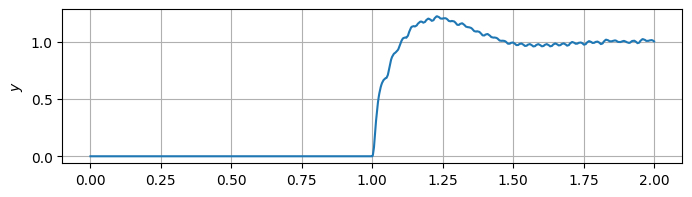

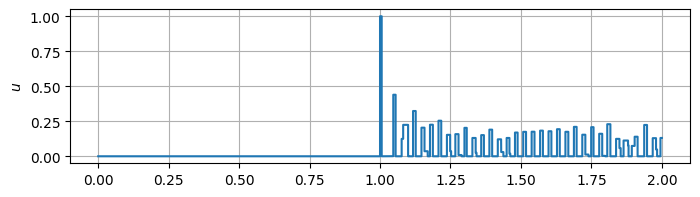

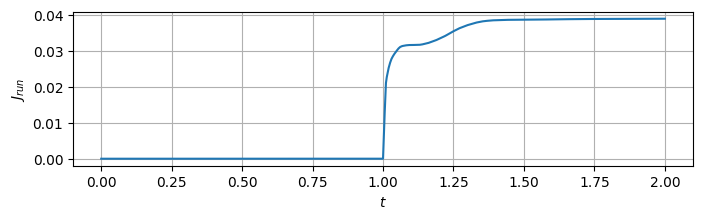

In [3]:
#  NOTE:
#  Using a standard manual tuning process, reasonable gains are something like
#  kp=0.5, ki=2.0, kd=0.01

# Create the reference block with default parmaeters
# step from 0 to 1 at t=1
reference = Step(name="reference")

# Make diagram with chosen cost parameters
diagram = make_diagram(R=0.01, dt=0.01, terminal_weight=0.0, reference=reference)
context = diagram.create_context()

t_span = (0.0, 2.0)
recorded_signals = {
    "plant.y": diagram["plant"].output_ports[0],
    "controller.y": diagram["controller"].output_ports[0],
    "control_limits.y": diagram["control_limits"].output_ports[0],
    "cost.y": diagram["cost"].output_ports[0],
}
results = collimator.simulate(
    diagram,
    context,
    t_span,
    options=SimulatorOptions(max_major_steps=500),
    recorded_signals=recorded_signals,
)
sol = results.outputs

plt.figure(figsize=(8, 2))
plt.plot(results.time, sol["plant.y"])
plt.ylabel(r"$y$")
plt.grid()
plt.show()

plt.figure(figsize=(8, 2))
plt.step(results.time, sol["control_limits.y"])
plt.ylabel(r"$u$")
plt.grid()
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(results.time, sol["cost.y"])
plt.ylabel(r"$J_{run}$")
plt.xlabel(r"$t$")
plt.grid()
plt.show()

In [4]:
# Store this solution for later comparison
sol_initial = sol
sol_initial["time"] = results.time

# Optimize a single (long) trajectory

Here, we optimize the gains to track the step change in the reference value. This is not a good idea in terms of constructing a robust optimization problem, but conceptually it's the simplest approach.

Since we only have a single reference to track, there's no need to use a batched solver or SGD-type methods.  Instead, we can use a more efficient quasi-Newton optimizer. This is demonstrated below. We first create an efficient `forward` function, which given a set of gains $K_p$, $K_i$, and $K_d$, outputs the cost $J_{run}$. Then, we use a BFGS optimizer to find the minimum of this function.

In [5]:
from jax.scipy.optimize import minimize
from functools import partial

sys_config = {
    "dt": 0.01,
    "R": 0.01,
    "terminal_weight": 1.0,
    "reference": Step(name="reference"),
}

diagram = make_diagram(**sys_config)
t_span = (0.0, 2.0)
context = diagram.create_context()

controller = diagram["controller"]
J_run = diagram["cost"]["J_run"]

options = SimulatorOptions(enable_autodiff=True, rtol=1e-08, atol=1e-10)


@jax.jit
def forward(gains, context):
    ctrl_context = context[controller.system_id].with_parameters(
        {"kp": gains[0], "ki": gains[1], "kd": gains[2]}
    )
    context = context.with_subcontext(controller.system_id, ctrl_context)

    results = collimator.simulate(diagram, context, t_span, options=options)
    return results.context[J_run.system_id].continuous_state


initial_gains = jnp.array([1.0, 0.0, 0.0])
res = minimize(partial(forward, context=context), initial_gains, method="BFGS")
print(res.success, res.fun)
kp_opt, ki_opt, kd_opt = res.x
print(kp_opt, ki_opt, kd_opt)

True 0.013972113245297641
0.8092401236779772 2.6934790308779486 0.008933110215832192


Next, we write a `run_rollout` function to run a single forward run with the optimal parameters and plot the results. Optinally, we can provide an initial solution `sol_initial` to compare the results of the optimal parameters against the results of the initial solution. 

In [6]:
def run_rollout(sys_config, p_opt, xf=1.0, x0=None, sol_initial=None):
    tf = 2.0

    if sys_config.get("reference") is None:
        sys_config["reference"] = Step(
            start_value=0.0, end_value=xf, step_time=1.0, name="reference"
        )

    # Simulate the system with the trained controller
    system = make_diagram(**sys_config)
    context = system.create_context()

    controller = system["controller"]
    plant = system["plant"]

    # Create a new context with the proivide parameters p_opt
    ctrl_context = context[controller.system_id].with_parameters(
        {"kp": p_opt[0], "ki": p_opt[1], "kd": p_opt[2]}
    )
    context = context.with_subcontext(controller.system_id, ctrl_context)

    if x0 is None:
        x0 = jnp.array([0.0, 0.0])
    plant_context = context[plant.system_id].with_continuous_state(x0)
    context = context.with_subcontext(plant.system_id, plant_context)

    options = SimulatorOptions(max_major_steps=200)
    recorded_signals = {
        "plant.y": system["plant"].output_ports[0],
        "controller.y": system["controller"].output_ports[0],
        "control_limits.y": system["control_limits"].output_ports[0],
        "cost.y": system["cost"].output_ports[0],
    }
    results = collimator.simulate(
        system, context, (0.0, tf), options=options, recorded_signals=recorded_signals
    )
    sol = results.outputs
    sol["time"] = results.time

    fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

    if sol_initial is not None:
        axs[0].plot(sol_initial["time"], sol_initial["plant.y"], label="Initial")
        axs[1].step(sol_initial["time"], sol_initial["control_limits.y"])
        axs[2].plot(sol_initial["time"], sol_initial["cost.y"])

    axs[0].plot(sol["time"], sol["plant.y"], label="Optimized")
    axs[0].set_ylabel("$y$")
    axs[0].grid()

    axs[1].step(sol["time"], sol["control_limits.y"])
    axs[1].set_ylabel("$u$")
    axs[1].grid()

    axs[2].plot(sol["time"], sol["cost.y"])
    axs[2].set_ylabel("$J_\\text{run}$")
    axs[2].set_xlabel("$t$")
    axs[2].grid()

    axs[0].legend()

    plt.show()

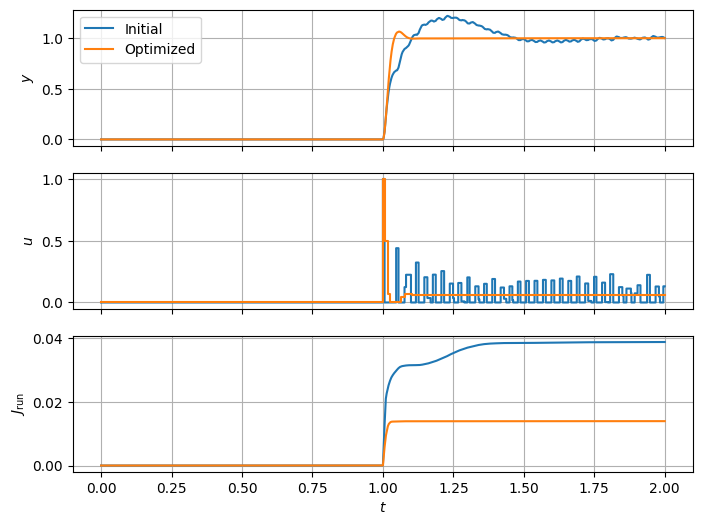

In [7]:
run_rollout(sys_config, p_opt=[kp_opt, ki_opt, kd_opt], sol_initial=sol_initial)

# Optimize over multiple (short) trajectories

For a more robust optimization strategy, instead of tracking a single step, we can define a "training set" of various set points and optimize the gains to track all of them.  Then we can evaluate on a longer "rollout" condition with the step change in the reference.

In this case, we can use the convenience utilities in `collimator.optimization` to construct a batched optimization problem.  Using SGD-type optimizers here will have a slightly slower convergence, but is likely to be more robust in this type of non-convex problem.

In [8]:
class PIDTrainer(Trainer):
    # Model-specific: what parameters can we optimize?
    def optimizable_parameters(self, context):
        controller = self.simulator.system["controller"]
        kp = context[controller.system_id].parameters["kp"]
        ki = context[controller.system_id].parameters["ki"]
        kd = context[controller.system_id].parameters["kd"]
        return kp, ki, kd

    # Model-specific updates to add the sample data, parameters, etc.
    # This should be the combination of the output of `optimizable_parameters`
    # along with all the per-simulation "training data".  Parameters will
    # update once per epoch, and training data will update once per sample.
    def prepare_context(self, context, params, x0, xr, key):
        kp, ki, kd = params
        system = self.simulator.system
        controller = system["controller"]
        reference = system["reference"]
        plant = system["plant"]

        ctrl_context = context[controller.system_id].with_parameters(
            {"kp": kp, "ki": ki, "kd": kd}
        )
        context = context.with_subcontext(controller.system_id, ctrl_context)

        ref_context = context[reference.system_id].with_parameters({"value": xr})
        context = context.with_subcontext(reference.system_id, ref_context)

        plant_context = context[plant.system_id].with_continuous_state(x0)
        context = context.with_subcontext(plant.system_id, plant_context)
        return context

    # Model-specific cost function
    def evaluate_cost(self, context):
        system = self.simulator.system
        cost_int_id = system["cost"]["J_run"].system_id
        J_run = context[cost_int_id].continuous_state
        J_fin = system["cost"]["J_fin"].output_ports[0].eval(context)
        return J_run + J_fin

In [9]:
def run_experiment(
    key,
    sys_config,
    tf=1.0,
    lr=1e-2,
    N=1000,
    epochs=50,
    batch_size=100,
):
    system = make_diagram(**sys_config)
    context = system.create_context()

    # Generate random initial conditions
    key, subkey = jax.random.split(key)
    # x0 = jax.random.uniform(subkey, (N, 2))
    x0 = jnp.zeros((N, 2))

    key, subkey = jax.random.split(key)
    xr = jax.random.uniform(subkey, (N,))

    # Reshape the initial conditions into a batch
    x0 = jnp.reshape(x0, (-1, batch_size, *x0.shape[1:]))
    xr = jnp.reshape(xr, (-1, batch_size))

    training_data = (x0, xr)

    options = SimulatorOptions(
        enable_autodiff=True,
        rtol=1e-08,
        atol=1e-10,
        max_major_steps=200
    )
    sim = collimator.Simulator(system, options=options)
    trainer = PIDTrainer(sim, context, lr=lr)
    opt_params = trainer.train(
        training_data, sim_start_time=0.0, sim_stop_time=tf, epochs=epochs
    )

    return opt_params

In [10]:
# To show this is more robust, we can start will all zeros for the gains
# and still get convergence to a good result.
sys_config = {
    "dt": 0.01,
    "R": 0.0,
    "kp": 0.0,
    "ki": 0.0,
    "kd": 0.0,
    "terminal_weight": 1.0,
}

opt_params = run_experiment(
    key=jax.random.PRNGKey(0),
    sys_config=sys_config,
    tf=0.1,
    lr=0.01,
    N=100,
    epochs=50,
    batch_size=10,
)
print(opt_params)

Epoch 0, loss=0.08432616298657698
Epoch 10, loss=0.015406233896533195
Epoch 20, loss=0.007646093595315994
Epoch 30, loss=0.005543921108200864
Epoch 40, loss=0.005032888723946662
(Array(0.61334639, dtype=float64), Array(1.60575254, dtype=float64), Array(0.00877541, dtype=float64))


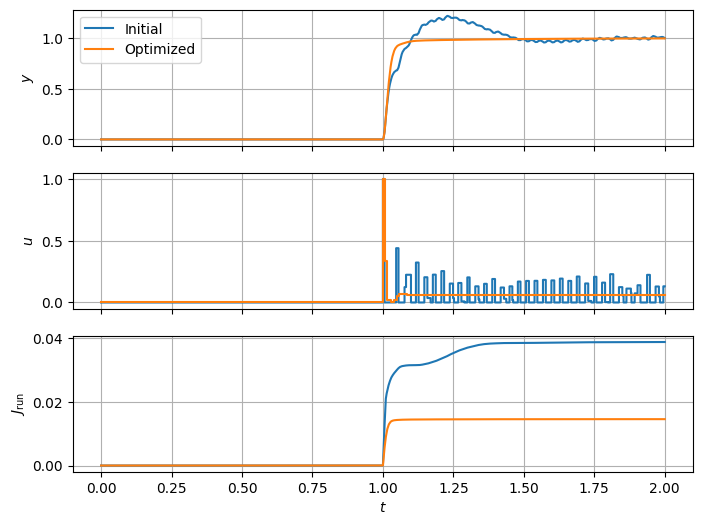

In [11]:
run_rollout(sys_config, opt_params, xf=1.0, sol_initial=sol_initial)

We find that the results of the robust optimization strategy are significantly better than optimization over a single trajectory.